In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools 
import scipy
import matplotlib
import glob
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scipy.io as sio
import matplotlib.mlab as mlab

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
length_list = [0, 248956422, 491149951, 689445510, 879660065, 1061198324,
               1232004303, 1391350276, 1536488912, 1674883629, 1808681051,
               1943767673, 2077042982, 2191407310, 2298451028, 2400442217,
               2490780562, 2574038003, 2654411288, 2713028904, 2777473071,
               2824183054, 2875001522, 3031042417]

chr_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20',
             '21', '22', 'X', 'Y']

v2_FILE = '/project/GCRB/Hon_lab/shared/former_members/s160875/03.analysis/Mosaic-seq/CROP-DE-analysis_10X-66K_no_downsampling-CPM.hg38/\
combine_10sgRNAs-volcano/generate_annotations/plot_annotation.txt'

annot_df = pd.read_csv(v2_FILE,
        header = None,
        sep='\t',
        names = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 'chr_idx'])

In [3]:
def outlier_plot(ax, fc_list, plot_x_val, plot_y_val, outlier_idx, plot_idx, color):
    outlier_fc = np.array([])
    outlier_y_val = np.array([])
    outlier_x_val = np.array([])
        
    idx = np.intersect1d(plot_idx, outlier_idx)
    for j in idx:
        if fc_list[j] > 1:
            outlier_fc = np.append(outlier_fc, get_fc_range(fc_list[j]))
        else:
            outlier_fc = np.append(outlier_fc, get_fc_range(1/fc_list[j]))
            
        outlier_x_val = np.append(outlier_x_val, plot_x_val[j])
        outlier_y_val = np.append(outlier_y_val, plot_y_val[j])
        
    ax.scatter(outlier_x_val, outlier_y_val,
               color=color,
               s=outlier_fc,
               marker='o',
               edgecolor='w')

def get_fc_range(val):
    if (val >= 4):
        fc_range = 200
    elif (val >= 2):
        fc_range = 100
    else:
        fc_range = 50
    return fc_range

## Load global hit df 
___

In [2]:
global_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 
                     'chr_idx', 'region', 'num_cell', 'bin', 'pval', 'fc', 
                     'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [3]:
DATA_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/'
SM_global_df = pd.read_csv(DATA_DIR + 'MB231_SM_global_hit.csv')[global_df_columns]
GWAS_global_df = pd.read_csv(DATA_DIR + 'MB231_GWAS_global_hit.csv')[global_df_columns]

### Filter df 

In [4]:
SM_plot_gene_idx = np.load(DATA_DIR + 'MB231_SM-5perc_expre_gene_idx.npy')
GWAS_plot_gene_idx = np.load(DATA_DIR + 'MB231_GWAS-5perc_expre_gene_idx.npy')

In [5]:
SM_express_df = SM_global_df[(SM_global_df['idx'].isin(SM_plot_gene_idx)) \
                                 &((SM_global_df['fc_by_rand_dist_cpm'] > 1.2) | (SM_global_df['fc_by_rand_dist_cpm'] < 0.8))\
                                 &(SM_global_df['padj-Gaussian'] < -50)\
                                 &(SM_global_df['num_cell'] > 500)
                                 ]

In [6]:
GWAS_express_df = GWAS_global_df[(GWAS_global_df['idx'].isin(GWAS_plot_gene_idx)) \
                                 &((GWAS_global_df['fc_by_rand_dist_cpm'] > 1.2) | (GWAS_global_df['fc_by_rand_dist_cpm'] < 0.8))\
                                 &(GWAS_global_df['padj-Gaussian'] < -50)\
                                 &(GWAS_global_df['num_cell'] > 500)
                                 ]

In [7]:
print(SM_express_df.shape)
print(GWAS_express_df.shape)

(5882, 14)
(3547, 14)


In [8]:
raw_global_df = GWAS_global_df.append(SM_global_df, ignore_index=True)

In [9]:
filter_global_df = GWAS_express_df.append(SM_express_df, ignore_index=True)

In [10]:
print(raw_global_df.shape)
print(filter_global_df.shape)

(21408150, 14)
(9429, 14)


## Volcano plot
___

In [39]:
DIR = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/Jupyter_plots/'

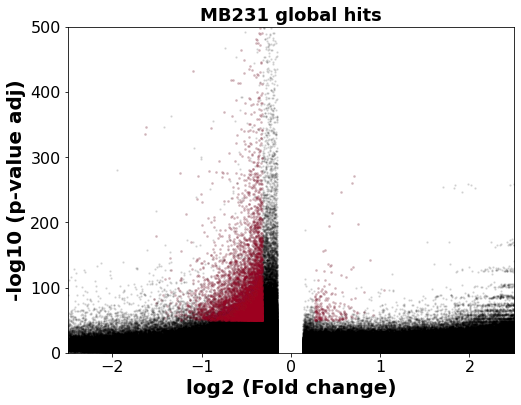

In [43]:
fig, ax = plt.subplots(figsize=(8,6))
#ax.set_facecolor('#E9E9E9')
#ax.grid(linestyle = '--')
ax.scatter(np.log2(raw_global_df['fc_by_rand_dist_cpm']),
          -raw_global_df['padj-Gaussian'],
          s=2,
          color='#000000',
          alpha=0.1)

ax.scatter(np.log2(filter_global_df['fc_by_rand_dist_cpm']),
          -filter_global_df['padj-Gaussian'],
          s=4,
          color='#A60628',
          alpha=0.1)

#label title and axises
ax.set_title('MB231 global hits',
         fontsize=18, fontweight='bold')
ax.set_xlim([-2.5,2.5])
ax.set_ylim([0,500])
ax.set_xlabel('log2 (Fold change)', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, color='#000000')
ax.set_ylabel('-log10 (p-value adj)', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16, color='#000000')
#plt.show()
plt.savefig(DIR + 'MB231_global_hit_volcano-250-v2.tiff')

## Calculation for stats table in paper
____

In [12]:
local_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 'chr_idx', 
                    'region', 'distance', 'num_cell', 'bin', 'pval', 'fc', 
                    'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [13]:
local_df = pd.read_csv('./MB231-filter_local_df.csv')[local_df_columns]

In [14]:
local_df.shape

(335, 15)

In [14]:
# for each test region, median # of local hits
collections.Counter(local_df['region']).values()

dict_values([2, 2, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
np.median([2, 2, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

1.0

In [16]:
# for each gene hit, median # of local region 
collections.Counter(local_df['gene_names']).values()

dict_values([1, 3, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
np.median([1, 3, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

1.0

### global

In [4]:
global_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 
                     'chr_idx', 'region', 'num_cell', 'bin', 'pval', 'fc', 
                     'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [5]:
global_df = pd.read_csv('./MB231-expressed_global_hit.csv')[global_df_columns]

In [6]:
global_df.shape

(9429, 14)

In [23]:
np.median([4, 1, 1, 2, 3, 1, 4, 7, 1, 2, 2, 1, 1, 3, 2, 1, 1, 2, 6, 5, 2, 2, 1, 2, 2, 3, 1, 2, 3, 2, 2, 1, 1, 3, 3, 1, 2, 4, 3, 1, 1, 3, 3, 2, 1, 10, 2, 3, 1, 1, 9, 1, 1, 1, 1, 4, 1, 3, 3, 3, 2, 7, 2, 5, 2, 3, 3, 3, 1, 4, 1, 2, 1, 1, 2, 3, 1, 4, 3, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, 1, 6, 2, 2, 1, 3, 1, 1, 3, 4, 2, 2, 3, 1, 2, 2, 2, 1, 4, 1, 5, 3, 6, 1, 1, 1, 2, 1, 2, 1, 3, 1, 2, 2, 1, 2, 3, 1, 3, 1, 3, 2, 4, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 5, 2, 1, 1, 1, 1, 3, 1, 5, 2, 4, 2, 2, 3, 4, 1, 4, 2, 3, 1, 4, 1, 2, 1, 3, 6, 4, 4, 3, 5, 1, 1, 3, 2, 4, 4, 6, 2, 2, 1, 2, 9, 1, 1, 1, 3, 2, 1, 2, 1, 5, 1, 1, 6, 3, 1, 3, 4, 6, 1, 1, 2, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 5, 2, 2, 3, 5, 2, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 2, 2, 2, 2, 2, 5, 1, 1, 3, 3, 3, 3, 2, 1, 2, 2, 1, 4, 2, 1, 1, 3, 1, 1, 2, 3, 3, 2, 6, 3, 2, 6, 2, 4, 2, 2, 1, 3, 1, 2, 6, 1, 2, 12, 3, 3, 4, 2, 1, 1, 5, 3, 3, 7, 2, 1, 4, 1, 1, 5, 4, 1, 1, 2, 1, 2, 6, 2, 5, 2, 1, 1, 2, 2, 1, 2, 2, 2, 3, 1, 1, 1, 1, 1, 2, 2, 2, 1, 6, 1, 6, 3, 1, 12, 2, 3, 1, 4, 1, 2, 2, 3, 1, 1, 1, 2, 1, 1, 5, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 4, 2, 3, 3, 2, 6, 1, 2, 2, 6, 1, 4, 2, 3, 1, 2, 1, 1, 2, 2, 3, 1, 9, 1, 1, 6, 3, 2, 2, 1, 1, 1, 3, 1, 1, 1, 2, 6, 3, 3, 4, 3, 1, 3, 1, 2, 4, 1, 3, 2, 3, 1, 1, 1, 2, 3, 1, 2, 2, 3, 2, 2, 2, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 4, 4, 1, 3, 2, 1, 2, 2, 4, 2, 6, 3, 1, 2, 2, 2, 3, 2, 1, 2, 1, 2, 3, 1, 1, 1, 3, 1, 3, 1, 1, 2, 1, 2, 3, 3, 2, 2, 3, 3, 1, 1, 2, 5, 3, 4, 1, 9, 1, 4, 2, 1, 2, 1, 1, 4, 1, 4, 3, 1, 3, 1, 2, 1, 3, 2, 5, 5, 3, 1, 2, 3, 1, 2, 3, 1, 1, 1, 2, 2, 1, 3, 4, 3, 1, 1, 1, 5, 4, 1, 4, 1, 1, 3, 2, 4, 4, 2, 2, 1, 5, 1, 3, 3, 2, 3, 2, 2, 1, 1, 1, 1, 5, 1, 3, 3, 3, 3, 3, 4, 1, 2, 4, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 5, 1, 4, 3, 1, 1, 4, 1, 4, 3, 2, 1, 5, 5, 3, 2, 2, 2, 4, 2, 3, 1, 4, 1, 2, 2, 1, 2, 6, 3, 1, 6, 1, 1, 2, 5, 4, 3, 2, 2, 3, 3, 4, 3, 2, 1, 2, 2, 1, 2, 1, 5, 1, 1, 1, 6, 3, 2, 2, 2, 7, 7, 2, 2, 2, 2, 3, 2, 3, 1, 2, 1, 2, 4, 5, 2, 3, 1, 3, 1, 1, 3, 1, 2, 3, 4, 4, 1, 4, 4, 1, 3, 2, 3, 1, 4, 3, 1, 2, 3, 2, 1, 2, 1, 5, 1, 1, 1, 1, 1, 4, 1, 2, 1, 2, 3, 1, 1, 1, 4, 6, 7, 5, 3, 2, 1, 1, 1, 1, 1, 1, 4, 5, 4, 1, 2, 2, 1, 8, 3, 1, 5, 1, 1, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 1, 4, 4, 2, 1, 1, 3, 4, 3, 3, 6, 2, 5, 4, 1, 1, 1, 1, 2, 2, 3, 3, 1, 1, 1, 1, 3, 2, 2, 8, 1, 2, 4, 1, 3, 6, 2, 1, 2, 2, 1, 3, 1, 3, 1, 2, 1, 3, 1, 3, 2, 1, 2, 7, 1, 2, 1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 5, 3, 1, 4, 1, 3, 1, 1, 1, 4, 1, 2, 4, 3, 2, 2, 1, 1, 3, 2, 1, 12, 1, 1, 1, 1, 7, 1, 1, 2, 1, 2, 1, 3, 5, 2, 2, 3, 1, 1, 2, 2, 2, 1, 4, 4, 1, 4, 3, 2, 1, 4, 7, 4, 3, 1, 4, 1, 1, 2, 1, 1, 2, 3, 3, 4, 5, 3, 3, 1, 1, 4, 2, 4, 2, 2, 1, 3, 4, 5, 1, 1, 4, 3, 2, 1, 2, 1, 7, 6, 1, 2, 2, 1, 1, 3, 2, 2, 1, 1, 2, 1, 1, 4, 1, 3, 1, 5, 8, 5, 5, 4, 1, 1, 2, 2, 1, 2, 3, 2, 3, 5, 5, 4, 1, 3, 1, 1, 3, 1, 2, 1, 3, 3, 2, 3, 1, 7, 4, 1, 1, 4, 2, 1, 2, 7, 1, 1, 2, 1, 2, 3, 1, 1, 4, 1, 1, 1, 4, 4, 1, 2, 1, 1, 2, 2, 2, 3, 4, 2, 3, 1, 1, 1, 1, 5, 2, 2, 1, 2, 1, 1, 1, 1, 1, 5, 1, 2, 1, 3, 2, 1, 2, 2, 1, 2, 2, 2, 3, 3, 3, 1, 5, 4, 4, 1, 2, 2, 4, 3, 2, 1, 7, 6, 4, 1, 5, 1, 3, 1, 2, 5, 4, 3, 1, 2, 3, 4, 1, 3, 1, 2, 3, 3, 1, 9, 4, 5, 3, 2, 2, 3, 3, 2, 2, 2, 2, 1, 5, 1, 3, 5, 2, 4, 4, 5, 4, 2, 2, 1, 2, 4, 1, 3, 2, 1, 7, 2, 2, 2, 2, 3, 1, 3, 1, 5, 1, 4, 4, 1, 2, 1, 2, 5, 5, 1, 4, 2, 1, 3, 4, 2, 3, 2, 2, 2, 1, 4, 2, 1, 1, 1, 1, 2, 4, 1, 2, 1, 2, 4, 1, 2, 3, 1, 2, 4, 6, 3, 1, 2, 1, 1, 1, 8, 1, 3, 1, 3, 1, 5, 5, 1, 2, 1, 1, 3, 2, 2, 1, 3, 1, 1, 3, 1, 2, 1, 2, 1, 4, 2, 1, 1, 3, 1, 1, 1, 1, 5, 4, 3, 3, 1, 2, 4, 3, 1, 1, 1, 3, 3, 2, 6, 2, 2, 1, 1, 1, 2, 4, 2, 4, 3, 2, 5, 2, 1, 1, 2, 2, 3, 5, 1, 2, 3, 1, 4, 3, 2, 1, 1, 1, 2, 2, 3, 1, 8, 6, 3, 6, 5, 2, 2, 1, 1, 3, 2, 3, 5, 4, 2, 2, 1, 1, 6, 6, 2, 1, 2, 2, 3, 1, 5, 2, 1, 2, 2, 5, 2, 2, 1, 2, 1, 4, 9, 2, 1, 1, 3, 3, 4, 1, 2, 2, 2, 6, 4, 2, 3, 4, 4, 2, 2, 5, 5, 1, 1, 1, 2, 2, 1, 3, 2, 3, 2, 1, 1, 3, 5, 3, 2, 3, 3, 2, 1, 6, 3, 2, 4, 1, 6, 5, 4, 1, 3, 1, 5, 1, 1, 1, 3, 7, 3, 1, 3, 2, 4, 2, 2, 2, 1, 4, 3, 2, 1, 3, 1, 3, 3, 2, 1, 2, 2, 1, 1, 2, 5, 1, 2, 1, 3, 8, 5, 1, 5, 1, 3, 2, 2, 5, 1, 3, 2, 1, 4, 4, 3, 1, 1, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 1, 2, 3, 3, 2, 5, 2, 1, 1, 1, 2, 1, 5, 6, 1, 1, 1, 5, 1, 3, 1, 4, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 3, 3, 2, 1, 7, 2, 5, 2, 1, 2, 4, 1, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 2, 2, 2, 4, 3, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 3, 4, 1, 1, 2, 1, 1, 1, 4, 3, 1, 3, 3, 2, 2, 2, 2, 4, 2, 1, 2, 1, 2, 1, 3, 1, 1, 3, 3, 3, 1, 2, 2, 8, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 1, 6, 1, 1, 2, 2, 1, 2, 2, 4, 2, 1, 3, 2, 3, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 3, 1, 2, 1, 2, 2, 3, 1, 2, 5, 2, 2, 4, 2, 1, 3, 1, 5, 9, 9, 2, 12, 12, 6, 1, 2, 2, 2, 1, 4, 5, 30, 6, 5, 3, 4, 7, 6, 5, 2, 2, 1, 3, 2, 3, 4, 11, 8, 16, 9, 1, 2, 4, 7, 1, 3, 3, 6, 9, 2, 4, 2, 4, 2, 4, 4, 1, 13, 5, 13, 4, 4, 10, 2, 4, 16, 7, 2, 2, 1, 15, 3, 9, 5, 14, 5, 1, 1, 1, 34, 1, 5, 9, 1, 4, 3, 13, 5, 1, 1, 1, 8, 1, 9, 2, 1, 15, 2, 1, 11, 7, 2, 1, 2, 3, 11, 1, 1, 5, 2, 4, 6, 4, 4, 4, 1, 1, 6, 5, 2, 1, 4, 1, 2, 8, 9, 2, 3, 3, 3, 2, 3, 14, 4, 7, 4, 12, 24, 15, 3, 8, 1, 2, 1, 5, 2, 10, 3, 1, 2, 1, 2, 1, 4, 16, 3, 6, 16, 23, 2, 2, 17, 3, 2, 1, 10, 1, 4, 5, 5, 1, 7, 3, 1, 1, 5, 21, 8, 1, 5, 5, 1, 10, 1, 15, 3, 3, 2, 10, 4, 6, 2, 7, 3, 1, 4, 15, 4, 1, 10, 6, 11, 9, 5, 3, 3, 2, 3, 1, 7, 5, 14, 4, 1, 4, 3, 5, 7, 13, 1, 9, 1, 11, 12, 2, 6, 1, 1, 19, 2, 5, 30, 1, 1, 5, 13, 1, 12, 3, 3, 1, 2, 10, 1, 12, 19, 22, 12, 3, 7, 2, 2, 8, 1, 14, 2, 1, 1, 3, 4, 7, 2, 1, 2, 1, 3, 1, 15, 1, 6, 7, 5, 3, 4, 20, 1, 4, 3, 3, 6, 3, 1, 2, 5, 4, 11, 13, 8, 1, 8, 11, 5, 2, 3, 2, 1, 1, 1, 2, 2, 2, 9, 1, 1, 8, 8, 5, 2, 3, 1, 15, 1, 5, 2, 2, 8, 1, 1, 1, 6, 2, 5, 4, 1, 2, 3, 1, 1, 13, 9, 4, 13, 8, 4, 3, 33, 16, 4, 2, 3, 1, 4, 3, 2, 7, 1, 10, 2, 4, 7, 6, 8, 2, 11, 6, 5, 9, 1, 6, 4, 4, 1, 12, 5, 4, 17, 4, 4, 3, 2, 4, 4, 3, 7, 2, 2, 3, 6, 3, 4, 3, 4, 9, 1, 8, 2, 3, 1, 1, 4, 19, 4, 1, 6, 1, 1, 1, 1, 4, 1, 5, 12, 2, 3, 1, 1, 1, 3, 12, 1, 10, 4, 2, 2, 2, 5, 1, 1, 1, 1, 4, 3, 1, 5, 3, 2, 2, 3, 1, 7, 1, 1, 1, 153, 4, 3, 1, 3, 5, 1, 2, 3, 2, 2, 10, 1, 5, 3, 3, 2, 5, 2, 2, 4, 3, 5, 1, 7, 1, 2, 1, 1, 2, 8, 1, 4, 1, 2, 5, 5, 10, 1, 1, 1, 4, 1, 3, 1, 1, 1, 3, 2, 1, 1, 2, 1, 7, 1, 1, 3, 1, 3, 3, 2, 5, 2, 2, 1, 2, 19, 6, 6, 1, 1, 4, 6, 1, 5, 1, 4, 1, 2, 8, 6, 5, 7, 2, 6, 1, 4, 9, 6, 14, 1, 5, 2, 4, 18, 1, 8, 3, 15, 13, 1, 7, 7, 3, 5, 1, 5, 27, 2, 4, 1, 8, 3, 16, 1, 8, 7, 4, 4, 1, 8, 2, 1, 8, 4, 1, 12, 1, 5, 13, 4, 1, 2, 2, 2, 4, 7, 2, 1, 2, 2, 4, 1, 4, 1, 5, 1, 4, 7, 5, 6, 2, 1, 1, 7, 2, 2, 2, 5, 1, 1, 5, 9, 17, 1, 2, 11, 2, 2, 1, 2, 2, 7, 4, 8, 1, 1, 4, 2, 5, 9, 16, 8, 9, 4, 4, 2, 4, 11, 7, 2, 2, 11, 1, 8, 1, 4, 7, 5, 2, 1, 2, 7, 2, 4, 4, 7, 1, 6, 4, 1, 6, 2, 1, 15, 7, 1, 6, 4, 3, 5, 1, 2, 1, 4, 2, 5, 7, 6, 3, 12, 2, 1, 4, 5, 1, 3, 4, 1, 3, 4, 2, 3, 1, 3, 5, 2, 4, 3, 9, 1, 2, 4, 9, 3, 6, 2, 3, 1, 2, 1, 2, 5, 13, 1, 2, 3, 12, 4, 3, 5, 15, 4, 3, 4, 6, 1, 2, 2, 2, 7, 11, 4, 2, 10, 1, 2, 3, 6, 8, 10, 1, 1, 1, 10, 3, 1, 2, 3, 6, 5, 17, 4, 9, 8, 1, 1, 2, 3, 3, 2, 12, 5, 1, 3, 2, 1, 1, 2, 4, 4, 10, 12, 3, 2, 3, 2, 5, 7, 3, 2, 1, 3, 11, 1, 11, 3, 3, 1, 11, 1, 2, 5, 1, 2, 1, 11, 3, 1, 7, 3, 3, 4, 2, 14, 1, 5, 3, 1, 8, 4, 4, 2, 1, 4, 6, 2, 1, 10, 3, 4, 2, 4, 11, 3, 5, 3, 2, 2, 2, 7, 3, 4, 5, 2, 1, 2, 4, 8, 2, 26, 8, 2, 9, 5, 4, 8, 4, 3, 4, 3, 3, 1, 4, 5, 8, 1, 1, 6, 2, 4, 1, 3, 3, 2, 3, 2, 9, 2, 4, 6, 1, 5, 1, 1, 1, 1, 3, 2, 3, 2, 20, 5, 11, 1, 2, 14, 3, 2, 1, 9, 3, 15, 9, 4, 5, 15, 6, 1, 3, 1, 3, 13, 4, 2, 12, 2, 10, 13, 9, 2, 16, 4, 2, 28, 5, 1, 2, 2, 2, 1, 21, 2, 3, 4, 9, 13, 4, 2, 16, 1, 2, 3, 4, 14, 5, 11, 3, 3, 5, 1, 9, 17, 10, 2, 10, 6, 7, 14, 28, 3, 2, 1, 7, 8, 1, 27, 3, 2, 1, 14, 1, 4, 3, 13, 3, 1, 3, 6, 2, 7, 6, 5, 5, 4, 6, 4, 5, 11, 9, 2, 3, 1, 1, 15, 1, 1, 16, 1, 7, 3, 3, 8, 5, 6, 5, 9, 1, 17, 10, 10, 5, 1, 6, 11, 2, 4, 7, 6, 2, 3, 5, 12, 1, 8, 2, 1, 1, 9, 14, 15, 6, 1, 8, 3, 9, 4, 11, 3, 3, 5, 18, 4, 5, 2, 2, 1, 1, 4, 2, 15, 4, 3, 12, 32, 1, 6, 3, 3, 10, 7, 6, 1, 1, 1, 8, 3, 1, 10, 1, 2, 1, 12, 3, 1, 10, 2, 6, 2, 2, 8, 3, 1, 3, 1, 2, 8, 2, 1, 5, 21, 1, 2, 6, 1, 1, 5, 1, 5, 2, 1, 7, 8, 8, 3, 1, 2, 3, 3, 1, 3, 4, 1, 2, 5, 2, 2, 3, 1, 1, 1, 2, 2, 3, 1, 7, 3, 6, 3, 4, 6, 6, 5, 3, 5, 1, 1, 2, 12, 9, 5, 5, 2, 2, 4, 3, 1, 16, 3, 4, 13, 5, 3, 6, 4, 1, 9, 3, 1, 1, 1, 1, 1, 2, 1, 2, 10, 10, 4, 1, 16, 9, 6, 2, 6, 2, 2, 6, 16, 6, 2, 2, 7, 2, 3, 3, 9, 1, 3, 10, 6, 2, 5, 1, 9, 1, 2, 3, 1, 6, 1, 19, 1, 4, 1, 1, 2, 1, 3, 1, 7, 4, 1, 4, 4, 1, 4, 1, 1, 3, 2, 1, 5])

2.0

In [25]:
np.median([3, 2, 2, 1, 4, 1, 2, 1, 2, 4, 2, 3, 6, 2, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2, 1, 4, 4, 1, 3, 4, 1, 3, 6, 1, 1, 4, 4, 2, 1, 2, 3, 1, 2, 6, 2, 4, 1, 2, 2, 4, 4, 2, 1, 3, 3, 3, 3, 2, 1, 1, 2, 2, 3, 3, 1, 4, 4, 2, 1, 1, 2, 1, 2, 3, 2, 3, 1, 2, 1, 1, 3, 2, 3, 3, 3, 2, 1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 3, 5, 3, 2, 3, 3, 4, 1, 1, 5, 1, 1, 2, 2, 2, 1, 2, 5, 3, 3, 3, 4, 5, 2, 1, 5, 3, 2, 2, 2, 3, 2, 1, 2, 2, 5, 2, 3, 7, 2, 3, 1, 1, 1, 3, 1, 1, 3, 2, 1, 4, 3, 1, 4, 2, 4, 2, 2, 2, 3, 4, 6, 2, 2, 3, 2, 3, 5, 1, 7, 3, 1, 4, 2, 1, 2, 3, 2, 4, 2, 4, 6, 4, 1, 2, 2, 3, 4, 4, 1, 2, 1, 3, 4, 3, 1, 2, 3, 4, 1, 3, 4, 3, 2, 1, 2, 2, 4, 1, 3, 2, 4, 6, 1, 4, 3, 1, 3, 2, 3, 2, 1, 2, 2, 2, 2, 1, 2, 8, 5, 3, 2, 4, 2, 3, 2, 4, 4, 5, 1, 3, 5, 4, 3, 3, 1, 1, 4, 1, 3, 1, 2, 3, 5, 4, 1, 2, 2, 2, 3, 1, 2, 1, 3, 4, 4, 2, 4, 5, 7, 3, 3, 3, 4, 4, 3, 1, 3, 2, 1, 3, 2, 2, 2, 3, 2, 1, 3, 6, 2, 2, 5, 5, 1, 3, 4, 5, 3, 2, 4, 2, 4, 1, 2, 1, 1, 1, 2, 3, 3, 4, 5, 3, 2, 1, 3, 2, 3, 2, 1, 2, 2, 4, 2, 4, 2, 2, 3, 1, 1, 4, 2, 4, 1, 2, 3, 3, 5, 4, 2, 2, 1, 1, 2, 3, 2, 3, 5, 1, 2, 2, 3, 2, 3, 4, 5, 1, 3, 1, 5, 3, 3, 3, 1, 1, 3, 2, 2, 3, 3, 2, 6, 4, 2, 4, 2, 4, 3, 3, 3, 1, 2, 3, 1, 3, 2, 7, 2, 1, 3, 3, 1, 5, 1, 4, 2, 6, 1, 3, 3, 5, 1, 2, 1, 2, 1, 1, 1, 3, 1, 1, 2, 3, 3, 1, 1, 4, 1, 2, 5, 1, 8, 4, 2, 4, 5, 2, 1, 3, 4, 4, 3, 1, 3, 1, 4, 4, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 3, 2, 2, 4, 2, 3, 4, 3, 4, 2, 4, 3, 2, 2, 4, 1, 3, 4, 2, 4, 3, 4, 2, 1, 1, 4, 2, 2, 3, 2, 2, 4, 1, 1, 3, 2, 3, 3, 1, 4, 3, 3, 1, 1, 5, 3, 1, 1, 4, 1, 2, 2, 5, 3, 1, 3, 1, 2, 2, 6, 4, 2, 1, 3, 1, 2, 3, 2, 1, 4, 3, 7, 3, 4, 1, 4, 1, 4, 4, 8, 2, 4, 1, 3, 2, 3, 2, 4, 2, 2, 1, 1, 4, 3, 3, 1, 2, 1, 3, 1, 3, 1, 4, 1, 1, 2, 3, 1, 1, 2, 4, 1, 1, 3, 5, 3, 1, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 3, 1, 1, 4, 2, 1, 2, 1, 2, 4, 2, 1, 3, 1, 4, 3, 3, 6, 2, 5, 3, 3, 2, 4, 1, 1, 2, 2, 1, 4, 2, 5, 3, 5, 3, 3, 5, 2, 2, 3, 1, 1, 2, 1, 1, 4, 3, 2, 2, 1, 1, 3, 3, 4, 2, 1, 3, 1, 6, 1, 3, 3, 1, 2, 4, 3, 4, 1, 1, 3, 3, 2, 5, 1, 1, 1, 1, 2, 3, 3, 1, 2, 1, 3, 1, 1, 1, 4, 2, 2, 2, 1, 2, 2, 1, 4, 2, 1, 1, 2, 5, 3, 2, 2, 1, 1, 3, 5, 1, 1, 3, 2, 3, 2, 2, 3, 1, 2, 2, 4, 1, 2, 2, 2, 2, 2, 1, 3, 2, 1, 1, 4, 2, 1, 4, 4, 1, 6, 4, 4, 2, 2, 1, 4, 3, 3, 9, 2, 1, 2, 2, 2, 4, 2, 1, 1, 2, 4, 3, 1, 2, 4, 2, 3, 5, 1, 1, 2, 2, 4, 5, 1, 3, 1, 1, 1, 1, 3, 1, 3, 5, 2, 2, 4, 6, 1, 2, 1, 3, 4, 3, 1, 2, 1, 4, 1, 2, 3, 1, 6, 7, 2, 1, 2, 2, 3, 3, 1, 1, 1, 1, 2, 3, 1, 6, 1, 1, 1, 1, 1, 1, 8, 1, 3, 5, 3, 1, 1, 5, 3, 2, 1, 4, 3, 3, 4, 1, 1, 3, 2, 1, 3, 1, 1, 2, 2, 2, 1, 2, 1, 3, 1, 2, 1, 1, 2, 3, 2, 4, 3, 1, 3, 2, 3, 3, 2, 1, 2, 3, 2, 1, 2, 3, 1, 1, 4, 1, 2, 2, 1, 1, 2, 3, 2, 2, 1, 2, 2, 1, 3, 1, 1, 2, 2, 2, 2, 1, 2, 8, 2, 3, 3, 3, 1, 3, 1, 3, 1, 2, 2, 1, 1, 2, 4, 1, 1, 4, 2, 3, 6, 1, 1, 1, 3, 3, 3, 1, 3, 1, 2, 2, 2, 3, 2, 3, 1, 1, 4, 3, 1, 1, 5, 3, 3, 2, 5, 1, 2, 2, 2, 2, 2, 2, 5, 3, 2, 2, 2, 4, 1, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 5, 3, 1, 3, 2, 3, 1, 5, 2, 4, 4, 2, 2, 2, 3, 2, 4, 3, 1, 2, 2, 2, 1, 1, 3, 1, 2, 1, 2, 7, 4, 1, 2, 2, 1, 2, 3, 2, 3, 2, 1, 3, 2, 5, 3, 2, 2, 1, 3, 2, 2, 1, 1, 1, 3, 2, 2, 3, 2, 1, 4, 3, 1, 3, 1, 2, 2, 1, 3, 3, 3, 2, 3, 2, 2, 3, 3, 2, 2, 1, 3, 1, 2, 3, 1, 1, 2, 1, 2, 5, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 5, 5, 2, 1, 4, 1, 4, 2, 2, 2, 3, 2, 2, 1, 2, 2, 4, 2, 3, 2, 1, 3, 3, 4, 3, 1, 2, 1, 2, 4, 1, 2, 2, 2, 2, 1, 2, 3, 2, 1, 3, 1, 4, 3, 2, 1, 2, 1, 4, 1, 1, 1, 1, 4, 1, 3, 3, 3, 3, 1, 2, 1, 3, 3, 1, 2, 2, 1, 4, 1, 1, 3, 2, 2, 3, 3, 2, 2, 3, 2, 1, 4, 2, 4, 3, 2, 4, 1, 2, 3, 3, 3, 5, 4, 1, 3, 3, 2, 1, 4, 3, 2, 2, 1, 4, 1, 1, 5, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 1, 6, 2, 5, 7, 3, 2, 3, 3, 3, 2, 1, 2, 5, 2, 1, 2, 3, 5, 2, 2, 6, 2, 3, 1, 2, 4, 5, 1, 1, 5, 1, 2, 2, 1, 1, 3, 4, 1, 1, 4, 2, 2, 1, 2, 1, 2, 1, 2, 1, 3, 1, 2, 5, 4, 3, 1, 4, 2, 1, 2, 3, 2, 2, 2, 3, 1, 3, 2, 2, 2, 2, 3, 2, 7, 6, 1, 2, 4, 1, 3, 1, 2, 2, 4, 4, 2, 3, 5, 3, 3, 3, 4, 3, 4, 4, 1, 1, 3, 3, 2, 3, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 3, 5, 3, 4, 2, 2, 3, 1, 4, 8, 1, 1, 1, 2, 3, 2, 2, 5, 2, 3, 3, 4, 2, 4, 2, 3, 2, 4, 3, 2, 3, 4, 2, 1, 4, 1, 1, 3, 3, 3, 2, 1, 1, 3, 1, 3, 1, 4, 5, 3, 2, 1, 4, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 3, 3, 2, 2, 2, 1, 5, 2, 4, 3, 3, 2, 1, 5, 2, 2, 1, 1, 3, 1, 2, 1, 2, 5, 1, 1, 2, 1, 2, 5, 1, 1, 2, 2, 4, 1, 2, 1, 3, 1, 1, 4, 2, 6, 3, 6, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 2, 2, 1, 1, 3, 2, 2, 1, 3, 1, 4, 4, 4, 3, 2, 1, 3, 1, 3, 2, 1, 1, 2, 1, 1, 1, 3, 2, 2, 3, 5, 2, 3, 4, 1, 2, 3, 3, 1, 1, 1, 3, 4, 3, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1, 5, 1, 1, 2, 2, 1, 3, 5, 2, 2, 1, 2, 1, 1, 1, 5, 1, 3, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 2, 1, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 3, 2, 2, 3, 1, 2, 3, 1, 1, 1, 3, 1, 1, 2, 1, 4, 2, 1, 1, 2, 2, 3, 2, 3, 2, 1, 3, 1, 4, 2, 1, 1, 2, 5, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 3, 4, 6, 3, 1, 1, 4, 3, 1, 1, 2, 3, 5, 1, 5, 1, 1, 6, 2, 3, 1, 4, 5, 5, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 2, 1, 2, 3, 1, 3, 3, 3, 1, 3, 1, 2, 3, 4, 2, 1, 2, 2, 2, 2, 3, 2, 1, 4, 2, 2, 1, 1, 6, 3, 7, 2, 3, 2, 3, 1, 2, 2, 7, 2, 4, 1, 2, 3, 3, 3, 1, 2, 1, 2, 2, 4, 3, 2, 5, 1, 2, 3, 3, 2, 1, 1, 2, 1, 4, 3, 4, 1, 1, 1, 4, 1, 2, 3, 1, 4, 1, 1, 2, 1, 1, 3, 2, 1, 3, 1, 4, 2, 1, 4, 1, 2, 1, 1, 2, 4, 3, 2, 2, 5, 2, 1, 2, 4, 4, 2, 2, 1, 4, 3, 1, 2, 1, 1, 3, 1, 1, 3, 1, 2, 5, 1, 2, 1, 1, 2, 1, 1, 1, 4, 3, 3, 3, 1, 1, 1, 3, 3, 2, 3, 1, 3, 1, 1, 1, 2, 1, 3, 6, 1, 4, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 4, 1, 1, 2, 2, 2, 1, 2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 1, 2, 4, 1, 4, 2, 2, 1, 1, 2, 3, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 3, 3, 2, 1, 2, 3, 2, 2, 1, 1, 1, 1, 2, 2, 4, 1, 4, 1, 3, 1, 1, 1, 1, 2, 4, 5, 2, 2, 2, 3, 1, 1, 2, 1, 1, 2, 3, 2, 2, 2, 1, 4, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 3, 2, 1, 3, 2, 3, 1, 3, 2, 1, 3, 3, 2, 4, 1, 2, 3, 1, 2, 2, 5, 2, 1, 1, 2, 2, 2, 3, 3, 3, 3, 1, 2, 1, 3, 1, 3, 3, 1, 3, 1, 1, 2, 5, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 2, 1, 4, 1, 2, 1, 1, 3, 2, 1, 3, 2, 1, 1, 1, 3, 2, 1, 2, 1, 1, 3, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 3, 1, 2, 2, 2, 3, 7, 1, 1, 3, 1, 3, 2, 4, 4, 1, 1, 1, 1, 2, 2, 5, 2, 2, 2, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 3, 1, 3, 2, 3, 1, 1, 1, 3, 1, 2, 1, 3, 1, 2, 1, 2, 1, 3, 2, 2, 5, 1, 1, 3, 1, 4, 1, 2, 3, 2, 1, 1, 2, 3, 2, 1, 2, 2, 1, 4, 3, 2, 2, 2, 4, 2, 1, 4, 2, 1, 1, 1, 2, 1, 6, 5, 2, 4, 3, 1, 2, 1, 1, 2, 3, 4, 1, 3, 1, 3, 2, 2, 4, 1, 1, 4, 1, 3, 1, 1, 3, 3, 1, 1, 2, 1, 3, 3, 4, 3, 1, 1, 2, 1, 1, 2, 1, 3, 2, 3, 1, 4, 1, 2, 2, 5, 3, 5, 1, 2, 2, 3, 1, 3, 1, 3, 1, 4, 3, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 3, 2, 3, 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 3, 1, 2, 3, 1, 1, 1, 2, 4, 1, 4, 1, 3, 1, 1, 3, 1, 3, 1, 3, 4, 3, 2, 4, 1, 3, 3, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 3, 4, 1, 2, 1, 2, 2, 1, 2, 1, 4, 1, 1, 1, 1, 2, 2, 2, 3, 1, 1, 3, 1, 1, 3, 3, 2, 2, 1, 3, 3, 3, 4, 2, 1, 2, 1, 1, 2, 1, 1, 1, 3, 2, 4, 5, 2, 2, 3, 1, 1, 2, 1, 3, 1, 1, 4, 1, 1, 2, 2, 1, 2, 2, 1, 3, 4, 1, 4, 2, 1, 1, 2, 1, 1, 5, 2, 1, 2, 3, 3, 3, 5, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 3, 1, 4, 3, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 3, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 2, 3, 1, 1, 2, 2, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 5, 1, 2, 3, 2, 1, 1, 1, 3, 1, 4, 1, 2, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 3, 3, 1, 2, 1, 2, 1, 1, 3, 2, 2, 1, 1, 1, 1, 2, 2, 3, 1, 2, 2, 2, 2, 1, 3, 1, 2, 1, 4, 1, 2, 1, 1, 3, 1, 5, 4, 4, 1, 1, 2, 3, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 3, 3, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 3, 2, 1, 1, 2, 2, 3, 1, 2, 2, 1, 1, 2, 1, 4, 2, 5, 1, 2, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 5, 1, 1, 1, 1, 3, 3, 2, 2, 1, 2, 2, 1, 1, 3, 2, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 4, 2, 1, 3, 2, 3, 2, 2, 2, 1, 5, 2, 2, 2, 4, 1, 3, 2, 2, 2, 1, 2, 1, 1, 3, 2, 2, 2, 1, 2, 3, 1, 2, 1, 1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 1, 3, 4, 2, 2, 3, 5, 2, 1, 4, 1, 2, 3, 3, 1, 4, 2, 2, 1, 1, 2, 4, 4, 1, 5, 3, 1, 2, 2, 3, 1, 1, 1, 1, 4, 1, 2, 2, 2, 1, 3, 1, 2, 4, 2, 2, 4, 2, 1, 3, 3, 3, 4, 2, 1, 3, 2, 1, 1, 3, 2, 3, 1, 4, 3, 2, 1, 1, 1, 4, 3, 2, 1, 3, 1, 3, 1, 1, 3, 1, 2, 3, 2, 1, 1, 1, 2, 2, 1, 3, 3, 1, 2, 2, 2, 1, 2, 1, 3, 3, 3, 4, 1, 6, 1, 1, 2, 4, 1, 2, 2, 5, 3, 2, 1, 1, 2, 2, 1, 1, 2, 1, 4, 2, 1, 4, 2, 5, 5, 3, 4, 2, 2, 2, 2, 2, 1, 3, 2, 2, 1, 2, 3, 2, 1, 1, 2, 6, 3, 1, 2, 2, 2, 1, 1, 2, 2, 1, 3, 4, 1, 1, 2, 1, 3, 2, 1, 1, 1, 3, 1, 3, 2, 3, 1, 3, 1, 6, 4, 3, 1, 2, 6, 4, 2, 2, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 3, 2, 3, 3, 1, 2, 3, 2, 2, 3, 2, 1, 1, 1, 2, 3, 1, 1, 5, 2, 1, 3, 1, 4, 1, 5, 4, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 2, 1, 2, 2, 1, 3, 3, 2, 2, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 2, 2, 5, 4, 3, 1, 4, 4, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 3, 2, 4, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 3, 1, 4, 1, 1, 2, 1, 3, 3, 3, 1, 1, 1, 3, 2, 1, 3, 2, 2, 2, 1, 1, 1, 3, 2, 1, 1, 4, 2, 2, 2, 1, 2, 3, 1, 3, 1, 3, 2, 1, 1, 2, 2, 2, 2, 2, 3, 1, 3, 1, 2, 2, 1, 1, 5, 1, 2, 3, 3, 1, 4, 2, 1, 2, 1, 2, 2, 1, 6, 1, 3, 1, 1, 2, 2, 3, 1, 2, 1, 4, 4, 1, 1, 1, 3, 2, 4, 3, 2, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 4, 1, 1, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 1, 2, 1, 2, 3, 3, 1, 5, 1, 2, 2, 2, 1, 1, 1, 4, 1, 3, 1, 1, 1, 2, 6, 3, 1, 2, 1, 1, 3, 1, 2, 2, 1, 2, 1, 3, 1, 1, 2, 2, 2, 2, 4, 3, 1, 1, 3, 2, 1, 3, 2, 3, 2, 3, 3, 1, 2, 3, 1, 2, 1, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 3, 1, 2, 4, 1, 1, 2, 1, 2, 2, 1, 3, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 4, 1, 1, 3, 1, 2, 1, 4, 1, 3, 1, 1, 1, 2, 1, 1, 4, 3, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 5, 1, 2, 2, 1, 1, 3, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 1, 1, 1, 3, 2, 1, 5, 2, 1, 3, 1, 2, 1, 1, 4, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 1, 2, 1, 1, 1, 3, 1, 2, 2, 2, 2, 1, 1, 1, 2, 4, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 4, 2, 2, 1, 1, 2, 3, 3, 3, 2, 3, 1, 5, 1, 1, 2, 1, 2, 2, 2, 3, 1, 1, 1, 2, 3, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 4, 2, 2, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 3, 4, 3, 1, 4, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 3, 1, 4, 1, 1, 3, 2, 3, 1, 3, 1, 1, 1, 5, 2, 2, 4, 2, 2, 1, 1, 2, 3, 4, 2, 3, 3, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 3, 1, 2, 2, 2, 1, 1, 1, 1, 5, 2, 2, 2, 2, 3, 1, 1, 1, 2, 2, 3, 3, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 3, 2, 1, 4, 1, 2, 2, 2, 1, 2, 3, 1, 2, 3, 3, 1, 1, 2, 4, 6, 2, 1, 1, 2, 2, 2, 1, 2, 3, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 1, 1, 2, 3, 1, 3, 3, 1, 2, 1, 1, 3, 1, 2, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, 3, 2, 2, 1, 3, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 4, 2, 1, 1, 2, 1, 2, 1, 1, 3, 2, 2, 1, 2, 2, 1, 1, 3, 3, 1, 2, 2, 1, 2, 1, 1, 3, 1, 4, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 1, 1, 2, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 3, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 4, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 2, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 3, 3, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 1, 1, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 2, 1, 2, 1, 1, 3, 4, 2, 2, 1, 2, 2, 1, 4, 1, 1, 3, 2, 1, 3, 1, 2, 1, 3, 2, 2, 2, 1, 1, 2, 2, 1, 3, 1, 2, 2, 2, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, 3, 1, 2, 3, 1, 1, 2, 2, 1, 3, 1, 1, 2, 1, 3, 3, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 3, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 2, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 4, 2, 1, 3, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 1, 4, 1, 1, 1, 3, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 5, 2, 1, 2, 2, 1, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 4, 1, 1, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 4, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 2, 1, 1, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 3, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

2.0

In [7]:
collections.Counter(global_df['gene_names'].values).most_common()[:10]

[('STARD10', 9),
 ('ABLIM3', 8),
 ('ZNF143', 8),
 ('TBL2', 8),
 ('GNA13', 8),
 ('AHR', 8),
 ('EFCAB4A', 8),
 ('TRIP13', 7),
 ('EP300', 7),
 ('EFCAB2', 7)]

In [8]:
collections.Counter(global_df['region'].values).most_common()[:10]

[('chr22:23838946-23839573', 153),
 ('chr12:93784320-93784914', 34),
 ('chr7:15555494-15555994', 33),
 ('chr10:90930248-90930748', 32),
 ('chr1:160993528-160994056', 30),
 ('chr3:124564875-124565462', 30),
 ('chr10:61164738-61165238', 28),
 ('chr15:96317148-96317648', 28),
 ('chr1:161192648-161193148', 27),
 ('chr17:38768165-38768665', 27)]

## Each region global hits overlap rate
____

In [52]:
region_list = set(global_df['region'])

In [53]:
len(region_list)

2716

### Plotting

In [9]:
overlap_df = pd.read_csv('./MB231_global_overlap_rate.csv', index_col=0)

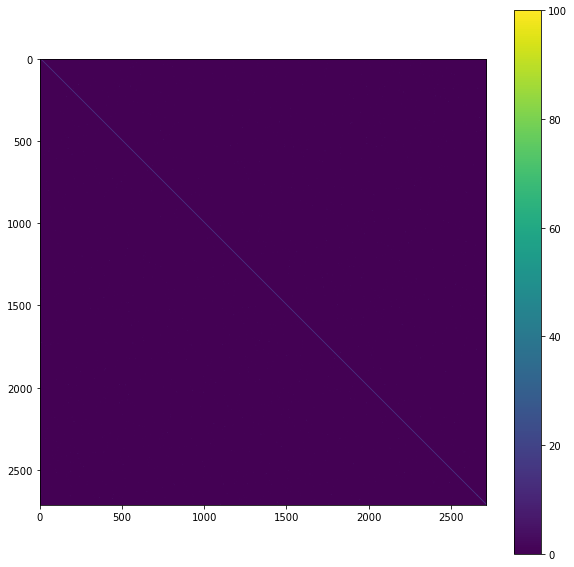

In [10]:
fig, ax = plt.subplots(figsize= (10, 10))

plt.imshow(overlap_df.astype(float)*100, cmap='viridis')
plt.colorbar()

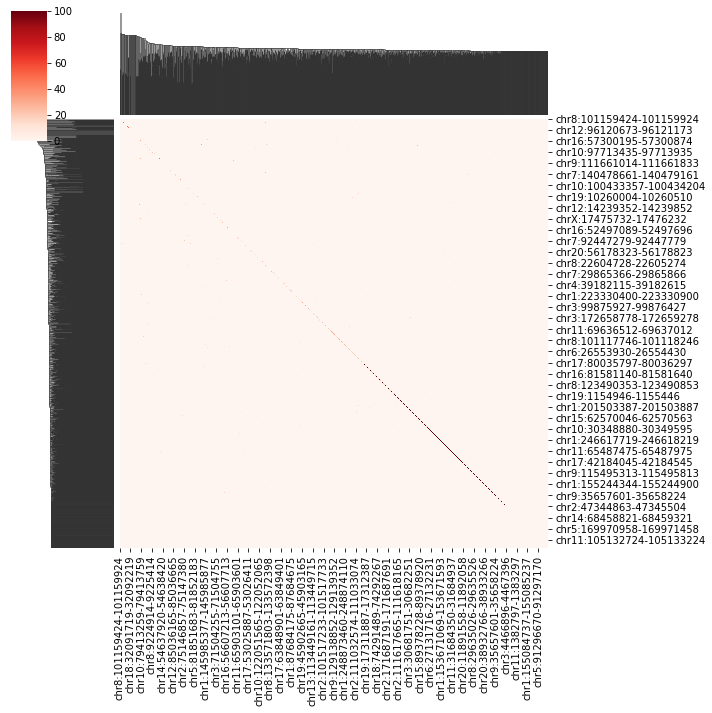

In [14]:
import seaborn as sns 
g = sns.clustermap(overlap_df.astype(float)*100, vmax=100, cmap='Reds')
plt.savefig('./figures/MB231_overlap_rate.png', dpi=600)

### Overlap num

In [15]:
overlap_df = pd.read_csv('./MB231_global_overlap_num.csv', index_col=0)

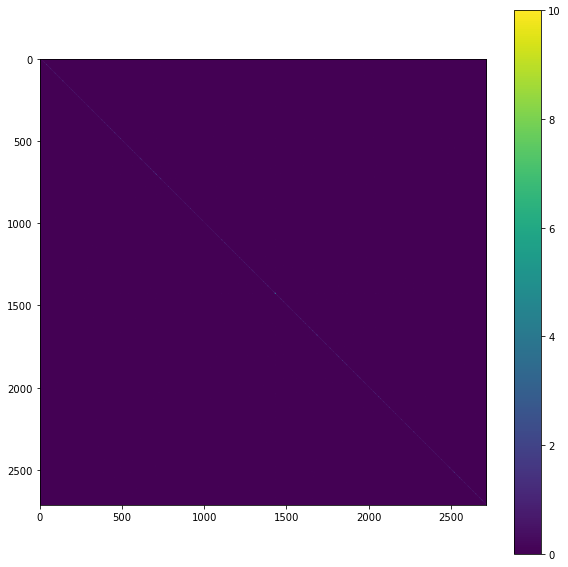

In [17]:
fig, ax = plt.subplots(figsize= (10, 10))

plt.imshow(overlap_df.astype(float), vmax=10, cmap='viridis')
plt.colorbar()

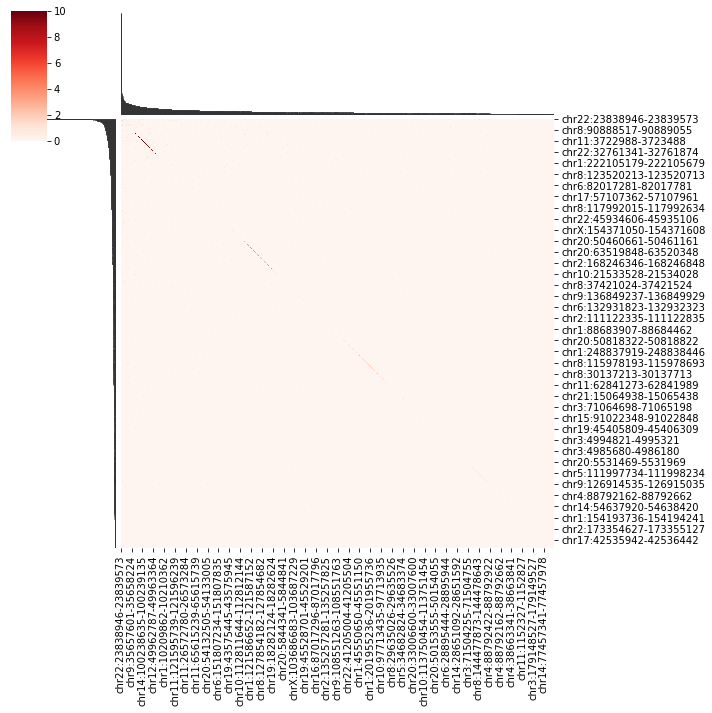

In [19]:
import seaborn as sns 
g = sns.clustermap(overlap_df.astype(float), vmax=10, cmap='Reds')
plt.savefig('./figures/MB231_overlap_num.png', dpi=600)